In [1]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'


# http://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost
import sys
import os

import pandas as pd
import numpy as np

# # Remote Data Access
# import pandas_datareader.data as web
# import datetime
# # reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')


In [2]:
#读取数据
sentiment = pd.read_csv('../数据集/时间序列/sentiment.csv',index_col=0,parse_dates=[0])
sentiment.head()

,UMCSENT
DATE,
2000-01-01,112.00000
2000-02-01,111.30000
2000-03-01,107.10000
2000-04-01,109.20000
2000-05-01,110.70000


In [3]:
sentiment.describe()

,UMCSENT
count,199.00000
mean,83.58844
std,12.28870
min,55.30000
25%,74.35000
50%,84.90000
75%,92.10000
max,112.00000


In [4]:
sentiment.tail()

,UMCSENT
DATE,
2016-03-01,91.00000
2016-04-01,89.00000
2016-05-01,94.70000
2016-06-01,93.50000
2016-07-01,90.00000


In [5]:
sentiment_short = sentiment.loc['2005':'2016']
sentiment_short.head(10)

,UMCSENT
DATE,
2005-01-01,95.50000
2005-02-01,94.10000
2005-03-01,92.60000
2005-04-01,87.70000
2005-05-01,86.90000
2005-06-01,96.00000
2005-07-01,96.50000
2005-08-01,89.10000
2005-09-01,76.90000


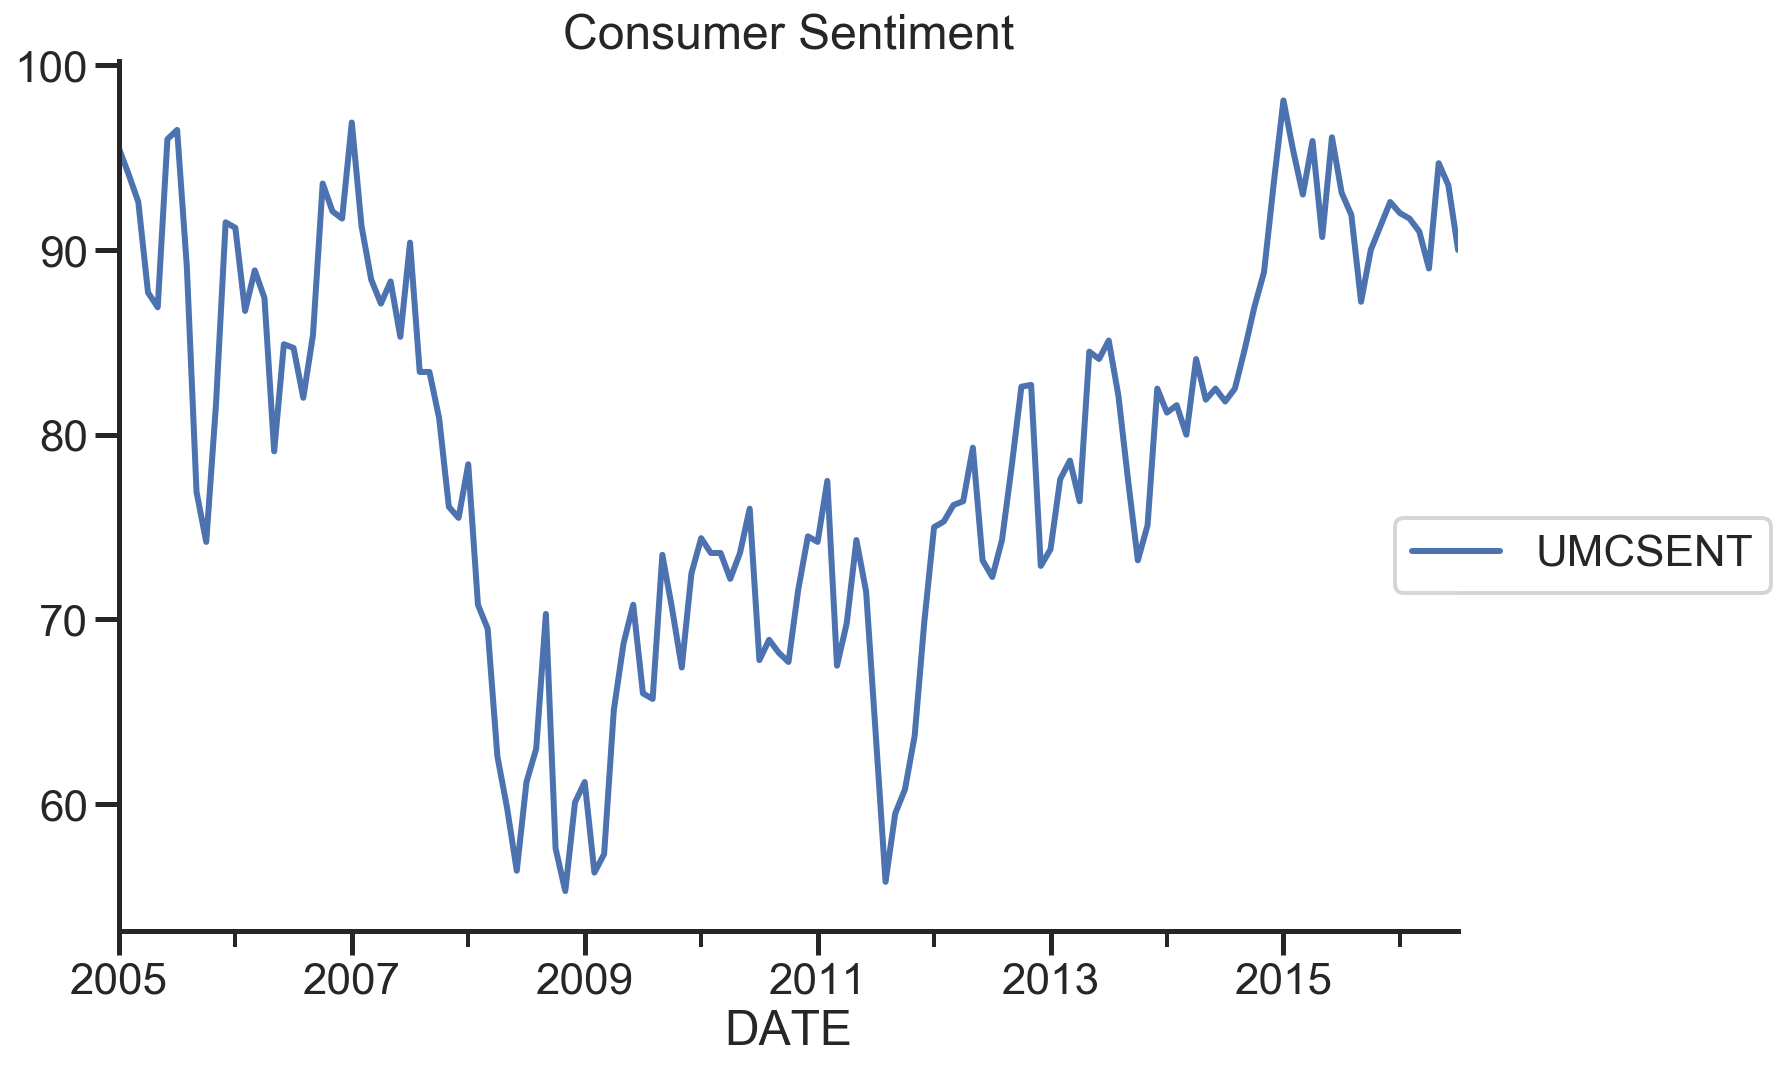

In [6]:
sentiment_short.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25,0.5))#表示legend的位置，前一个表示左右，后一个表示上下。当使用这个参数时。loc将不再起正常的作用
plt.title("Consumer Sentiment")
sns.despine()#　隐藏右边和上边的边框线。

In [7]:
#做一阶差分和二阶差分
sentiment_short['diff_1']=sentiment_short['UMCSENT'].diff(1)
sentiment_short['diff_2']=sentiment_short['diff_1'].diff(1)
sentiment_short.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UMCSENT,diff_1,diff_2
DATE,,,
2005-01-01,95.50000,nan,nan
2005-02-01,94.10000,-1.40000,nan
2005-03-01,92.60000,-1.50000,-0.10000
2005-04-01,87.70000,-4.90000,-3.40000
2005-05-01,86.90000,-0.80000,4.10000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001876AF7A7C8>,
      dtype=object)

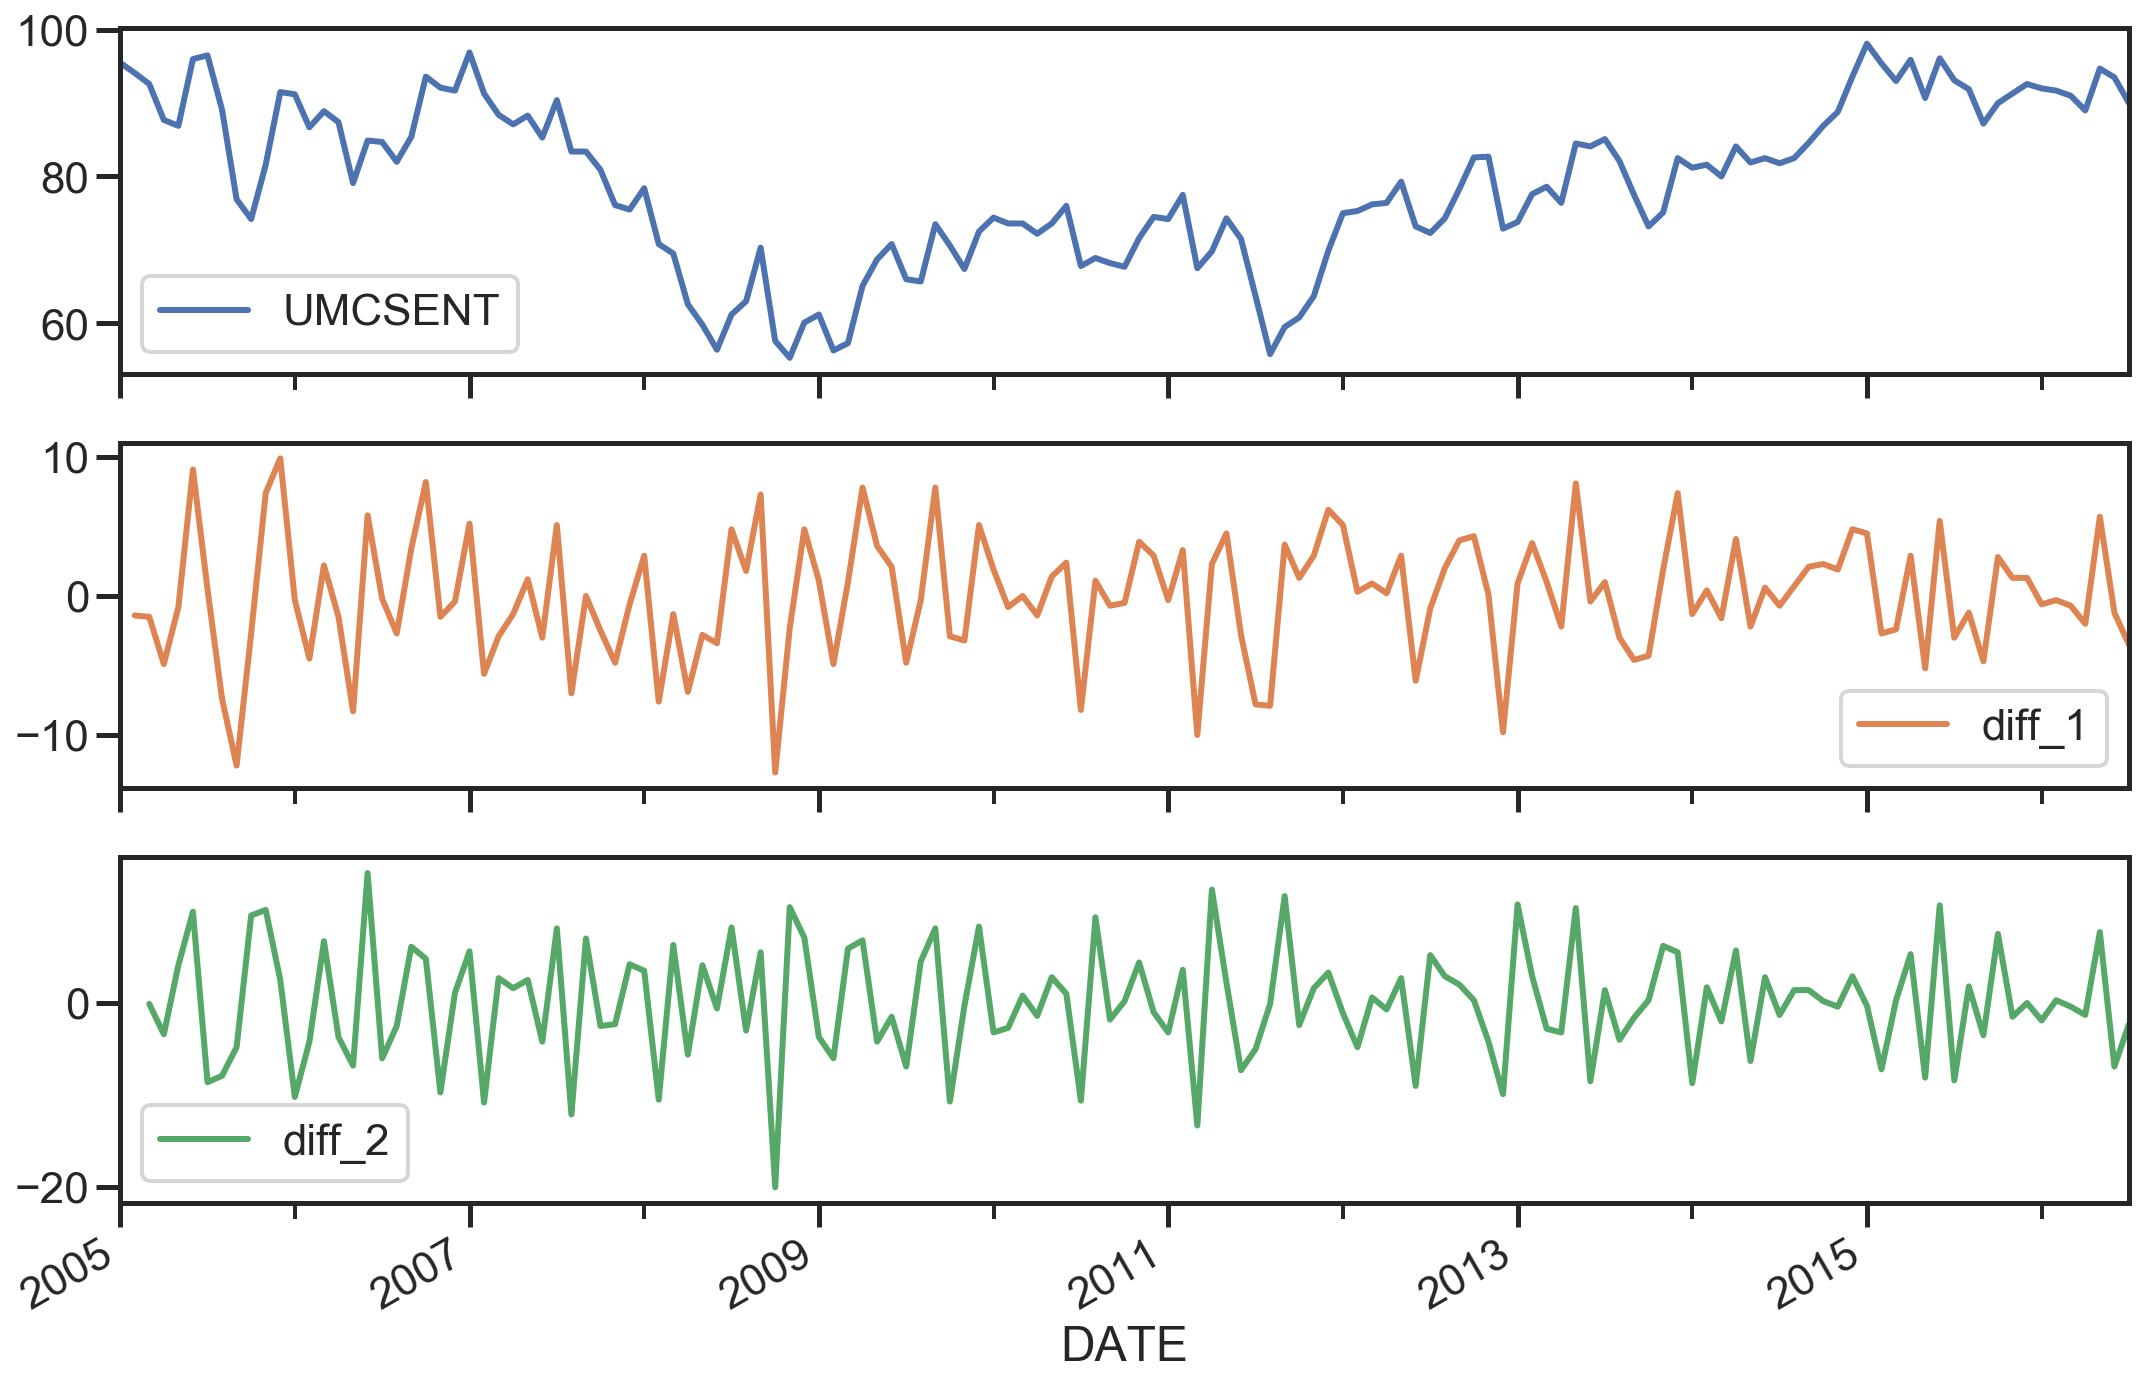

In [8]:
sentiment_short.plot(subplots=True,figsize=(18,12))

In [9]:
del sentiment_short['diff_2']
del sentiment_short['diff_1']

In [11]:
sentiment_short.head()
print(type(sentiment_short))

<class 'pandas.core.frame.DataFrame'>


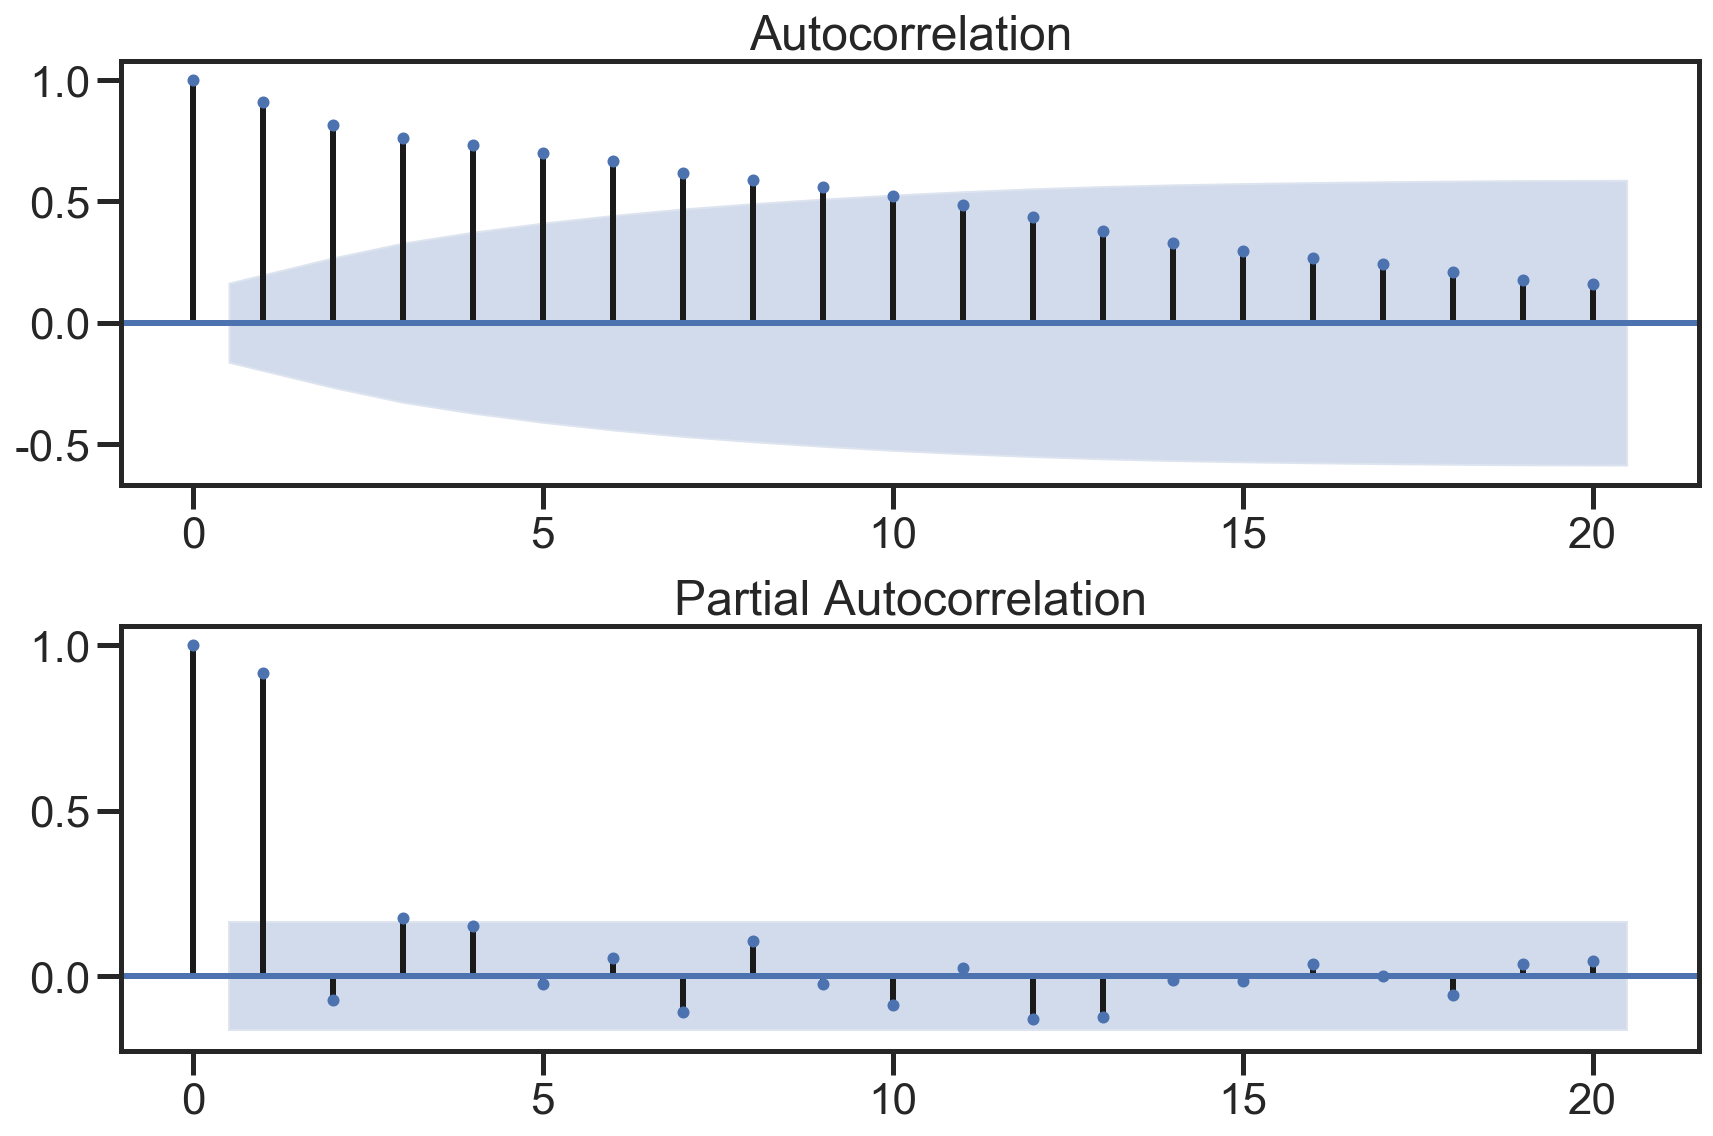

In [12]:
#绘制ACF图、PACF图确定p、q值，其中阴影部分代表p、q的置信区间
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short,lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short,lags=20,ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to s

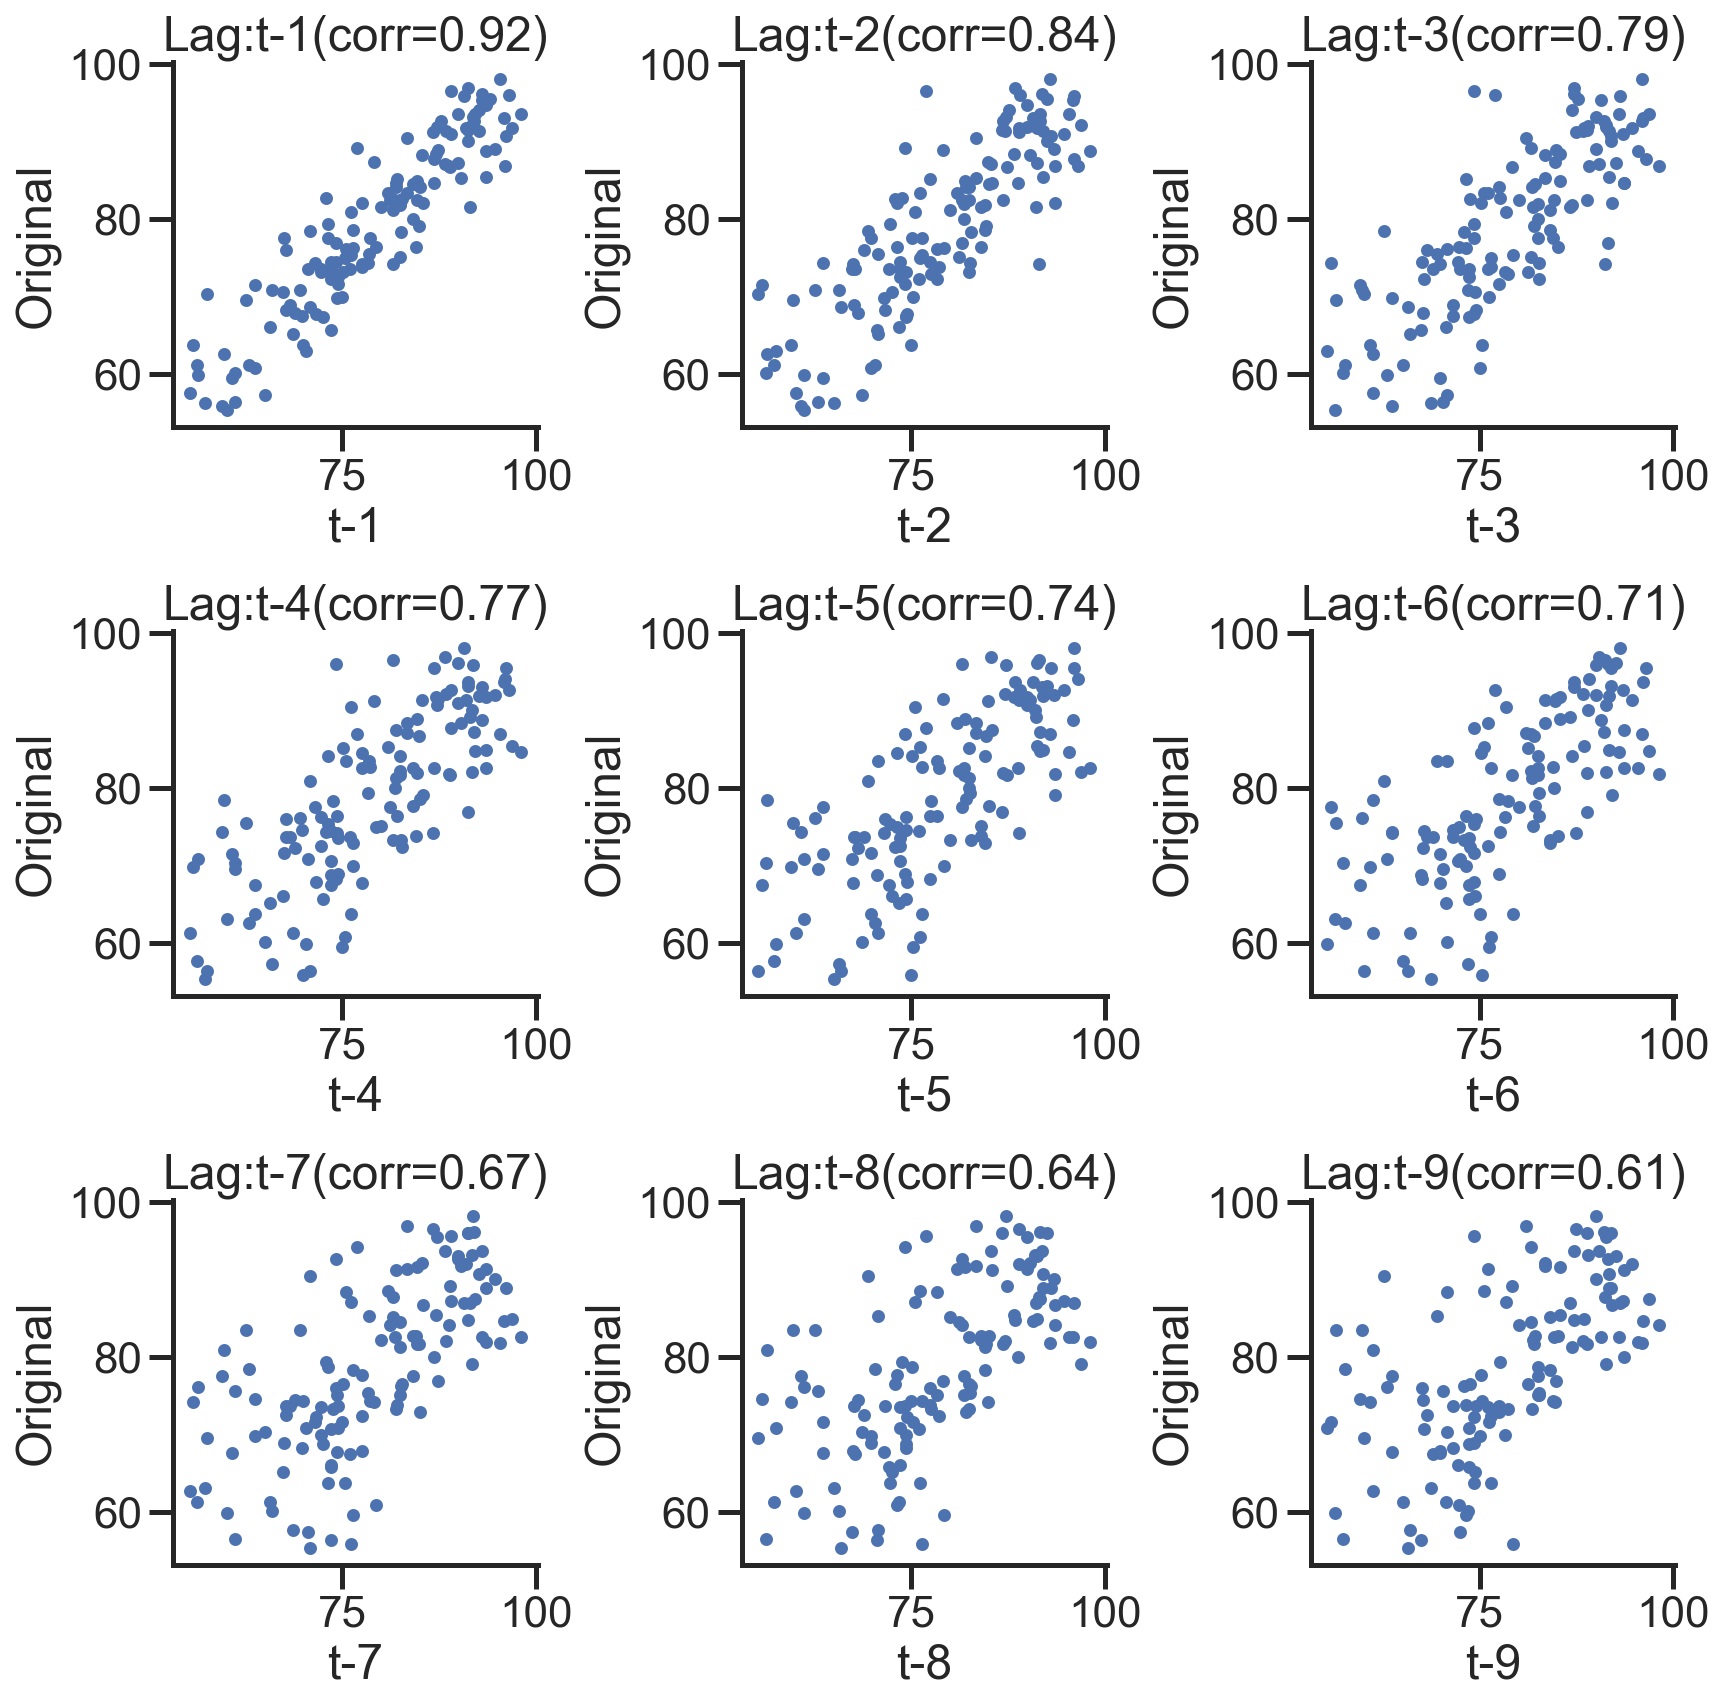

In [13]:
#使用散点图绘制原始数据和K阶差分数据之间的关系，并求出相关系数
lags = 9
ncols = 3
nrows = int(np.ceil(lags/ncols))
fig,axes = plt.subplots(ncols = ncols,nrows=nrows,figsize=(4*ncols,4*nrows))
for ax,lag in zip(axes.flat,np.arange(1,lags+1,1)):
    lag_str='t-{}'.format(lag)
    X = (pd.concat([sentiment_short,sentiment_short.shift(-lag)],axis=1,keys=['y']+[lag_str]).dropna())
    X.plot(ax=ax,kind='scatter',y='y',x=lag_str)
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag:{}(corr={:.2f})'.format(lag_str,corr))
    ax.set_aspect('equal')
    sns.despine()
    
fig.tight_layout()

(<matplotlib.axes._subplots.AxesSubplot at 0x1876b123608>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1876b484d08>)

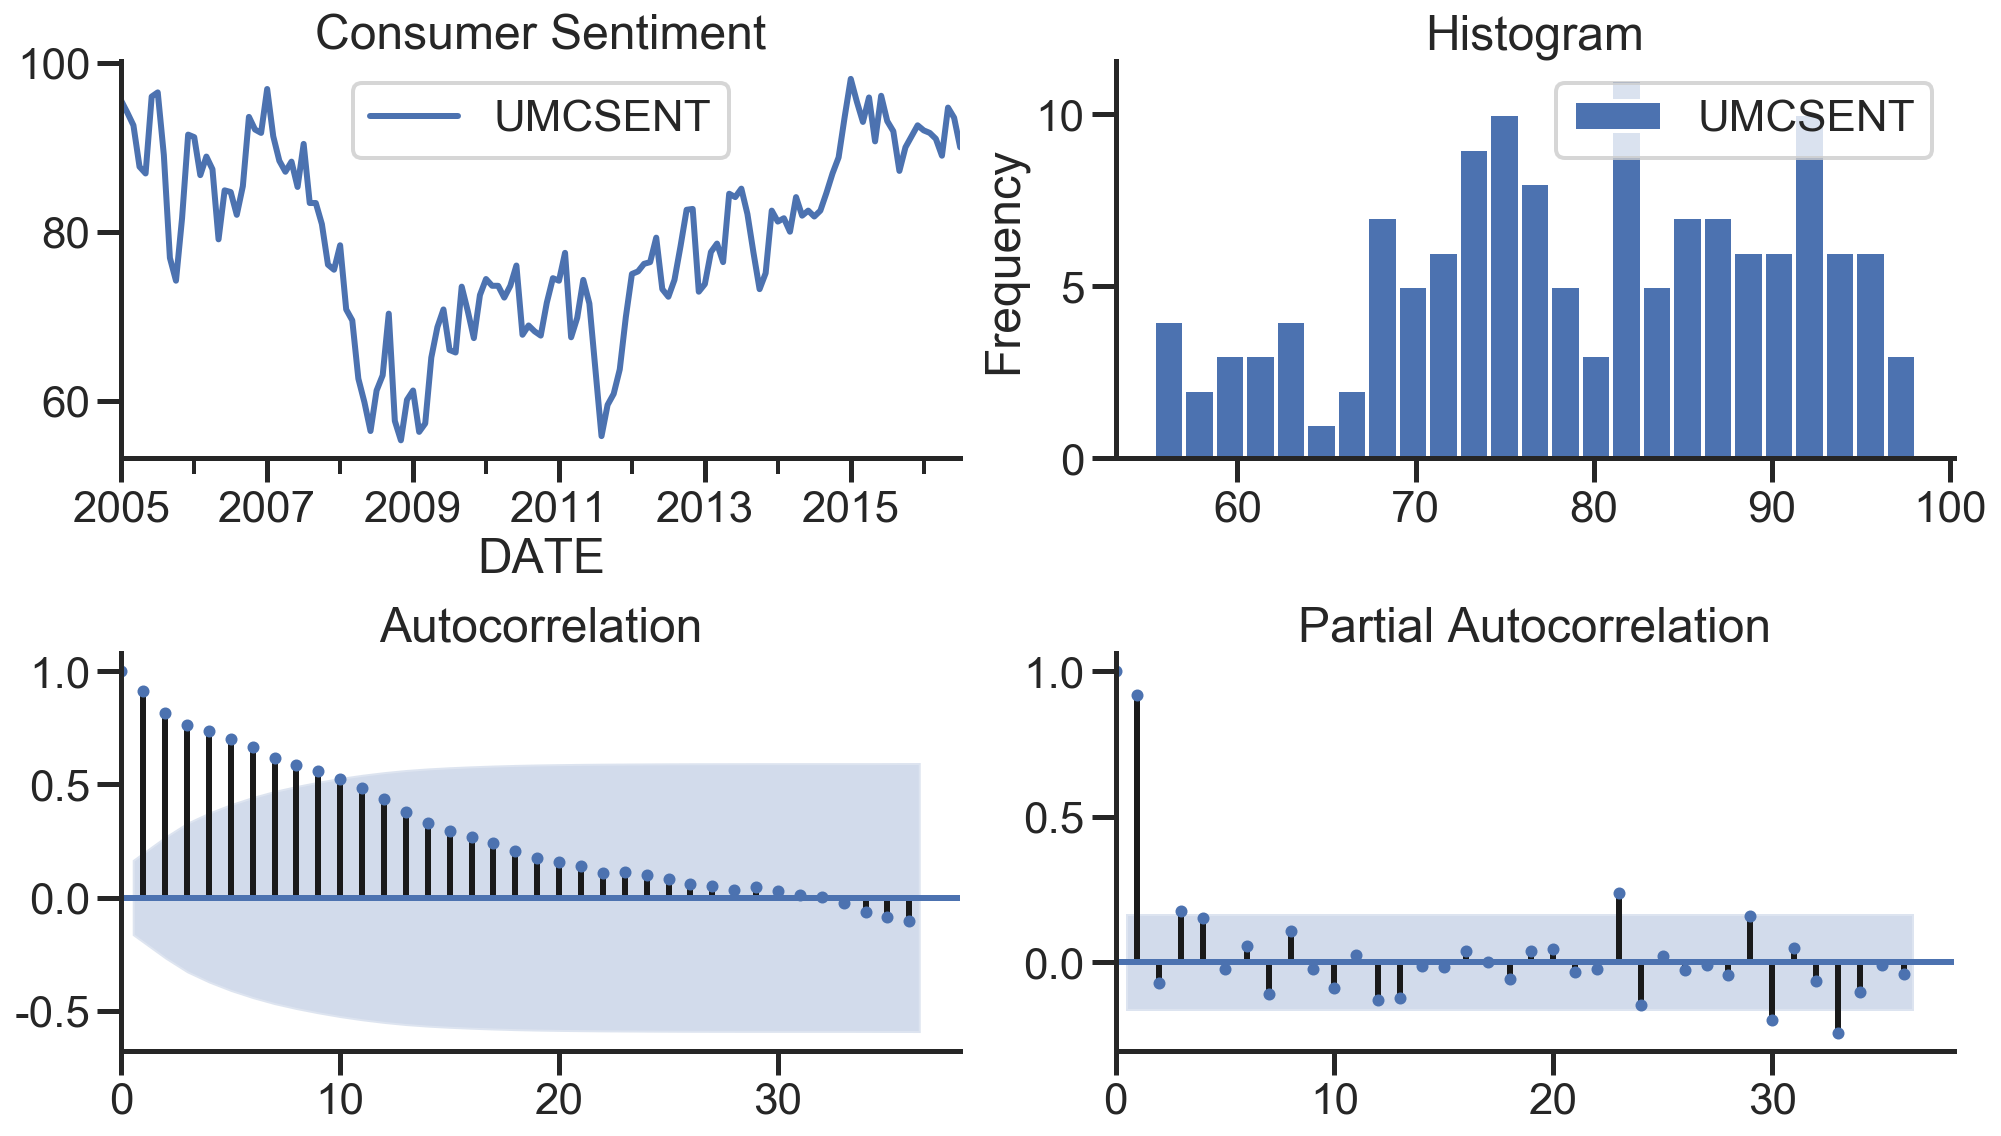

In [14]:
#在下图分别绘制原始数据的残差图、直方图、ACF图和PACF图
def tsplot(y,lags=None,title='',figsize=(14,8)):
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout,(0,0))
    hist_ax = plt.subplot2grid(layout,(0,1))
    acf_ax= plt.subplot2grid(layout,(1,0))
    pacf_ax = plt.subplot2grid(layout,(1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax,kind='hist',bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
    smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax,acf_ax,pacf_ax

tsplot(sentiment_short,title='Consumer Sentiment',lags=36)

# 新的数据集

In [17]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'


import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sentiment = pd.read_csv('../数据集/时间序列/series1.csv',index_col=0,parse_dates=[0])